In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
sales_df = pd.read_csv('out/sales_aggregated.csv', index_col=0)

In [24]:
sales_df = sales_df.transpose()

In [25]:
sales_df.columns.name = None
sales_df = sales_df.rename_axis("Date")
sales_df = sales_df.reset_index()

sales_df.head()

,Date,SCHAB Z KOŚCIĄ,SCHAB BEZ KOŚCI,KARCZEK BEZ KOŚCI,SZYNKA Z KOŚCIA,SZYNKA BEZ KOŚCI,ŁOPATKA Z KOŚCIA,ŁOPATKA BEZ KOŚCI,ŁOPATKA MIELONA,ŻEBERKO,BOCZEK,GOLONKA,PODGARDLE,SŁONINA BOCZKOWA,KOŚCI,SŁONINA,BŁONA,NOGI,PODROBY,WOŁOWE EXTRA,WOŁOWE OCZKO,PRĘGA,ŁATA,ROSOŁOWE,KURCZAK,FILET,ĆWIARTKA,UDKO,SKRZYDEŁKO,KORPUSY,ŁAPKI,PODROBY,POLĘDWICA SOPOCKA,SZYNKA DOMOWA,WĘDZONKA,BOCZEK CYGAŃSKI,KIEŁBASA SWOJSKA,KIEŁBASA DOMOWA,PIECZEŃ SWOJSKA,PIECZEN WĄTROBOWA,PASZTET,SALCESON,KASZANKA,PASZTETOWA,BOCZEK WEDZ-GOT,BOCZEK WĘDZONY,PODGZRDLE WĘDZONE,GOLONKA WĘDZONA,ŻEBERKA WĘDZONE,PARÓWKI,WĘDLINY
0,01_2015,181.920,192.732,156.977,0.00,177.450,280.98,157.570,244.28,250.190,297.690,174.49,201.86,206.810,264.825,485.360,36.63,237.022,84.55,91.901,204.490,23.490,15.63,236.832,23.28,39.22,36.690,0.000,26.80,23.39,11.45,0.00,10.240,43.27,2.511,30.070,73.180,56.633,114.40,38.218,0.0,42.47,97.598,34.470,3.490,87.550,33.40,0.72,2.24,0.00,29.580
1,02_2015,174.210,179.310,171.419,2.84,213.170,246.35,165.918,211.50,263.570,324.190,202.49,185.29,124.320,218.770,320.810,9.50,211.550,60.29,96.930,149.950,24.390,7.44,170.140,27.09,27.33,141.700,0.000,20.30,15.06,0.69,0.00,16.190,36.77,0.000,21.250,57.268,52.870,32.77,38.330,0.0,41.65,66.740,20.947,16.515,56.850,18.72,0.96,0.00,0.00,27.040
2,03_2015,391.492,331.325,301.939,62.11,385.080,378.56,377.568,392.25,435.851,562.710,285.76,265.17,180.401,330.100,485.920,9.50,338.250,79.37,175.560,278.850,50.460,15.39,273.570,48.79,407.39,141.700,122.350,30.47,164.11,0.69,54.11,31.740,99.66,2.640,30.475,118.508,140.800,52.47,75.130,0.0,64.70,107.050,33.805,49.825,82.562,27.23,2.14,0.91,31.61,34.290
3,04_2015,330.390,177.610,228.790,26.91,219.120,450.51,218.150,361.44,300.840,251.690,186.75,144.05,104.940,176.710,426.143,3.93,170.900,70.99,121.885,285.020,16.742,21.35,231.299,113.34,509.34,57.230,64.662,532.78,214.46,0.00,69.72,37.830,155.57,0.000,27.780,134.280,110.320,58.44,57.560,0.0,51.75,79.780,33.255,44.860,58.500,75.57,0.00,0.00,37.69,28.973
4,05_2015,459.240,159.792,272.260,33.65,215.273,279.39,257.570,363.41,387.389,362.242,228.66,142.26,129.300,231.710,318.080,1.41,139.297,79.18,124.739,244.772,32.880,83.27,225.960,184.11,573.32,41.862,186.180,80.53,202.61,0.00,63.47,41.325,98.47,11.260,37.920,95.730,153.425,100.23,69.642,0.0,49.72,103.800,51.710,53.247,77.560,39.19,0.92,3.48,14.22,43.280


### Melting the data to a better format

In [26]:
sales_df = sales_df.melt(id_vars=["Date"], var_name='Product', value_name='Sales in kg')

In [27]:
sales_df

,Date,Product,Sales in kg
0,01_2015,SCHAB Z KOŚCIĄ,181.920
1,02_2015,SCHAB Z KOŚCIĄ,174.210
2,03_2015,SCHAB Z KOŚCIĄ,391.492
3,04_2015,SCHAB Z KOŚCIĄ,330.390
4,05_2015,SCHAB Z KOŚCIĄ,459.240
...,...,...,...
5395,08_2023,WĘDLINY,513.860
5396,09_2023,WĘDLINY,580.460
5397,10_2023,WĘDLINY,691.890
5398,11_2023,WĘDLINY,622.950


### Feature engineering, encoding

In [28]:
def extract_season(value):
    month = str(value).split('_')[0]
    if month in ['12', '01', '02']: return "WIN"
    elif month in ['03', '04', '05']: return "SPR"
    elif month in ['06', '07', '08']: return "SUM"
    elif month in ['09', '10', '11']: return "FAL"

def include_holidays(value):
    month = str(value).split('_')[0]
    if month in ['03', '04']: return "EASTER"
    if month == "12": return "CHRISTMAS"


def feature_engineering(df):
    df['Holiday'] = df['Date'].apply(include_holidays)
    df['Season'] = df['Date'].apply(extract_season)
    return df
    
    
def encoding(df):
    return pd.get_dummies(df, columns=['Holiday', 'Season'], dtype=int)


    
    

sales_df = feature_engineering(sales_df.copy())
sales_df = encoding(sales_df.copy())

sales_df

,Date,Product,Sales in kg,Holiday_CHRISTMAS,Holiday_EASTER,Season_FAL,Season_SPR,Season_SUM,Season_WIN
0,01_2015,SCHAB Z KOŚCIĄ,181.920,0,0,0,0,0,1
1,02_2015,SCHAB Z KOŚCIĄ,174.210,0,0,0,0,0,1
2,03_2015,SCHAB Z KOŚCIĄ,391.492,0,1,0,1,0,0
3,04_2015,SCHAB Z KOŚCIĄ,330.390,0,1,0,1,0,0
4,05_2015,SCHAB Z KOŚCIĄ,459.240,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
5395,08_2023,WĘDLINY,513.860,0,0,0,0,1,0
5396,09_2023,WĘDLINY,580.460,0,0,1,0,0,0
5397,10_2023,WĘDLINY,691.890,0,0,1,0,0,0
5398,11_2023,WĘDLINY,622.950,0,0,1,0,0,0


### Transforming the data to fit the model

In [29]:
# converting Data column to pandas datetime and setting it as the index
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%m_%Y')
sales_df['Date'] = sales_df['Date'].dt.to_period('M') 
sales_df.set_index('Date', inplace=True)

In [30]:
#extracting single product sales
schab_z_koscia_sales = sales_df[sales_df['Product'] == 'SCHAB Z KOŚCIĄ']

schab_z_koscia_sales

,Product,Sales in kg,Holiday_CHRISTMAS,Holiday_EASTER,Season_FAL,Season_SPR,Season_SUM,Season_WIN
Date,,,,,,,,
2015-01,SCHAB Z KOŚCIĄ,181.920,0,0,0,0,0,1
2015-02,SCHAB Z KOŚCIĄ,174.210,0,0,0,0,0,1
2015-03,SCHAB Z KOŚCIĄ,391.492,0,1,0,1,0,0
2015-04,SCHAB Z KOŚCIĄ,330.390,0,1,0,1,0,0
2015-05,SCHAB Z KOŚCIĄ,459.240,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2023-08,SCHAB Z KOŚCIĄ,206.840,0,0,0,0,1,0
2023-09,SCHAB Z KOŚCIĄ,214.360,0,0,1,0,0,0
2023-10,SCHAB Z KOŚCIĄ,236.590,0,0,1,0,0,0


### Checking if the data is stationary

<Axes: xlabel='Date', ylabel='Sales in kg'>

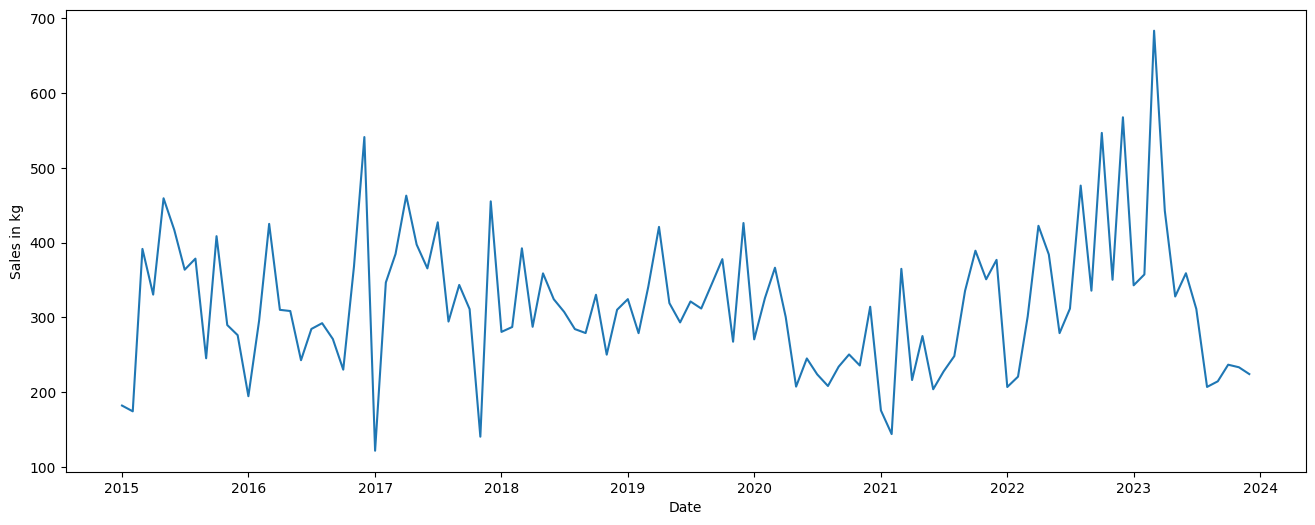

In [41]:
tmp = schab_z_koscia_sales.copy()
tmp.index = tmp.index.to_timestamp()


plt.figure(figsize=(16, 6))
sns.lineplot(data=tmp['Sales in kg'])

In [46]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(schab_z_koscia_sales['Sales in kg'])
print(f'ADF statistic (critical value):              {res[0]}')
print(f'p-value:                                     {res[1]}')
print(f'number of lags used in regression::          {res[2]}')
print(f'number of observations used in the analisys: {res[3]}')
print(f'Critical values (t-values):                  {res[4]}')


ADF statistic (critical value):              -3.7510839938674554
p-value:                                     0.0034493686371805934
number of lags used in regression::          2
number of observations used in the analisys: 105
Critical values (t-values):                  {'1%': np.float64(-3.4942202045135513), '5%': np.float64(-2.889485291005291), '10%': np.float64(-2.5816762131519275)}


### **Notes and observations**
-  **Null hypothesis** - it's saying that NON stationary data exists in the series
-  **Alternative hypothesis** - it's saying that stationary data exists in the series

__What we do to test the hypothesis, is :__
1. Compare the critical value to each t-value, and if its smaller, then we can reject the null hypothesis <br/>
    _(In this case -3.75 < -3.49, -2.88, -2.58)_
2. Establish a significance level, for example 5%, and check if the p-value is significant compared to it. If it isn't then we have a stronger reason to reject the null hypothesis <br/>
    _(In this case 0.003 < 0.05)_

##### __SUMMARY__ <br/>
Observations show that we can confidently reject the null hypothesis, and mark the data as __STATIONARY__

----

### Splitting the data

In [ ]:
y = schab_z_koscia_sales['Sales in kg']
X = schab_z_koscia_sales.drop(columns=[y.name, 'Product'])

X

,Holiday_CHRISTMAS,Holiday_EASTER,Season_FAL,Season_SPR,Season_SUM,Season_WIN
Date,,,,,,
2015-01,0,0,0,0,0,1
2015-02,0,0,0,0,0,1
2015-03,0,1,0,1,0,0
2015-04,0,1,0,1,0,0
2015-05,0,0,0,1,0,0
...,...,...,...,...,...,...
2023-08,0,0,0,0,1,0
2023-09,0,0,1,0,0,0
2023-10,0,0,1,0,0,0


### Testing the model
#### TO DO:
- research about ARIMA and SARIMA
- engineer more features


In [ ]:
import statsmodels.api as sm

sarimax_model = sm.tsa.SARIMAX(y, )


TypeError: SARIMAX.__init__() missing 1 required positional argument: 'endog'